# DPI Analysis: Recursive tool with *features-engine*

In [15]:
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import itertools
from feature_engine.selection import DropHighPSIFeatures

# load data

### Iris dataset

In [16]:
from sklearn.datasets import load_iris
# dataset
dataset1 = load_iris()
# data
df1 = pd.DataFrame(dataset1.data, columns = dataset1.feature_names)
df1['target'] = dataset1.target
# display
df1.shape

(150, 5)

### Titanic dataset

In [17]:
# load data
df2 = sns.load_dataset('titanic')
# get categorical columns
cats = ['object', 'category', 'bool', 'datetime64[ns]']
cols_cat_titanic = df2.select_dtypes(include=cats).columns.tolist()
# display
df2.shape

(891, 15)

# ANALYSIS

## TOOL: MSIP values estimation to test if pairs of samples of same variable have the same distribution (only numerical variables)

In [18]:
def results_dict_to_df(transformer, pairs_samples):
    dfout = pd.DataFrame([list(transformer.psi_values_.values())], columns = list(transformer.psi_values_.keys()))
    dfout.index = ['-'.join([str(ip) for ip in pairs_samples])]
    return dfout

In [33]:
## MSIP analysis to test if samples of variables has different distribution
def analysis_msip(df:pd.DataFrame, col_group:str, cols_analysis:list = [], minimum_size_sample:int = 10, threshold_samples_are_diff:float = .25, verbose:bool = True):
    """
    MSIP analysis to test if samples of variables has different distribution. It will be estimated MSIP values for each selected variable between pairs of samples 
    collected according to the categorical variable of groups. 
    
    df -- Data to be analized. 
    col_group -- Categorical variable to be used to split data in samples.
    cols_analysis -- Variables to be analyzed (default, []: all variables except column to be used to split).
    minimum_size_sample -- Minimun size to warning for a category with small size (default, 10).
    threshold_samples_are_diff -- Threshold to consider that two samples of same variables have different distribution (default, 0.25).
    verbose -- Display extra information (defaut, True).
    return -- Table wigh MSIP values for the selected variables for each pair of samples according to categories of group column.
    """
    # validate inputs
    assert col_group in df.columns.tolist()
    # if columns to be analyzed was not selected
    if len(cols_analysis) == 0:
        cols_analysis = [c for c in df.columns.tolist() if c != col_group]
    # validate
    for c in cols_analysis:
        assert c in df.columns.tolist(), f'Column "{c}" is required.'
    # get categories of group column
    categories = list(df[col_group].unique())
    # validate number of categories
    if len(categories) > 24:
        print(f'[warning] The number of categories is too large = {len(categories)}')
    # get all possible combinations of categories
    combinations = list(itertools.combinations(categories,r=2))
    # loop of combinations
    for iii, comb in enumerate(combinations):
        # collect data for pair of categories
        temp = df[df[col_group].isin(comb)][cols_analysis + [col_group]].copy()
        # drop records with nan values
        ni = len(temp)
        temp.dropna(inplace = True)
        nf = len(temp)
        if verbose:
            print(f'[warning] It was removed {ni-nf} records with nan values.')
        # estimate sample sizes
        nsample_i = temp[temp[col_group] == comb[0]].shape[0]
        nsample_f = temp[temp[col_group] == comb[1]].shape[0]
        # validate if there are not data in any category
        if nsample_i <= minimum_size_sample or nsample_f <= minimum_size_sample :
            print(f'[warningh] There are not data in one of this cagories {comb} in column "{col_group}".')
        # analysis for pair of categories
        transformer = DropHighPSIFeatures(split_col=col_group, cut_off=[comb[-1]])
        transformer.fit(temp)
        # results: dict to df
        temp_out = results_dict_to_df(transformer, comb)
        # collect list of analyzed columns
        cols_analyzed = temp_out.columns.tolist()
        # add sample sizes information
        temp_out["samples_sizes"] = [f'{nsample_i}/{nsample_f}']
        # append
        if iii == 0:
            dfout = temp_out.copy()
        else:
            dfout = dfout.append(temp_out)
        # clean
        del temp, temp_out, transformer

    # validate if samples are different for any vairable
    if (dfout[cols_analyzed] > threshold_samples_are_diff).sum().sum() > 0 and verbose:
        print('[info] There are samples with different distributions for some variable:')
        print(dfout[cols_analyzed] > threshold_samples_are_diff)
        
    # return
    return dfout

## PLOT: ECDF of samples according a categorical variable for several variables (numerical and categorical variables)

In [34]:
## plot distribution of a column
def ecdf(df:pd.DataFrame, column:str, column_group:str, ax:"matplotlib axis")->"matplotlib axis":
    # validation
    assert column in df.columns.tolist(), f"column '{column}' is not available."
    # plot
    ax = sns.ecdfplot(data=df, x=column, hue=column_group, ax = ax)
    # return axis
    return ax


# plot selected columns
def plots_ecdf(df:pd.DataFrame, columns:"list or str", column_group:str, plot_function:"function", num_plots_per_row:int = 3):
    # if columns is only one string    
    if isinstance(columns, str):
        # figsize
        figsize = (10, 10)
        # number of plots in rows / columns
        nrs = ncs = 1
    # if is a list
    elif isinstance(columns, list):
        # number of columns to be ploted
        ncolumns = len(columns)
        # number of plots in rows / columns
        nrs = math.ceil(ncolumns / num_plots_per_row)
        ncs = num_plots_per_row if ncolumns >= num_plots_per_row else ncolumns 
        # figsize
        figsize = (ncs*5, nrs*5)    
    else:
        raise
    # create figure and axis    
    fig, ax = plt.subplots(ncols = ncs, nrows = nrs, figsize = figsize)
    # if axis is an array
    if isinstance(ax, np.ndarray):
        # reshape
        ax = ax.ravel()
        # loop of axis
        for ii, c in enumerate(columns):
            # plot in cells
            _ = plot_function(df, c, column_group, ax[ii])
    # if axis is only one
    else:
        # plots only one
        _ = plot_function(df, columns[0] if len(columns) == 1 else columns, column_group, ax)
    # display plot
    plt.show()

## Analysis: iris dataset

In [35]:
analysis_msip(df1, 'target', verbose = False)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0-1           5.640071          4.705352           8.510299          7.244271   
0-2           7.975678          3.212474           8.067924          8.484241   
1-2           1.947136          0.532496           6.686912          7.207593   

    samples_sizes  
0-1         50/50  
0-2         50/50  
1-2         50/50

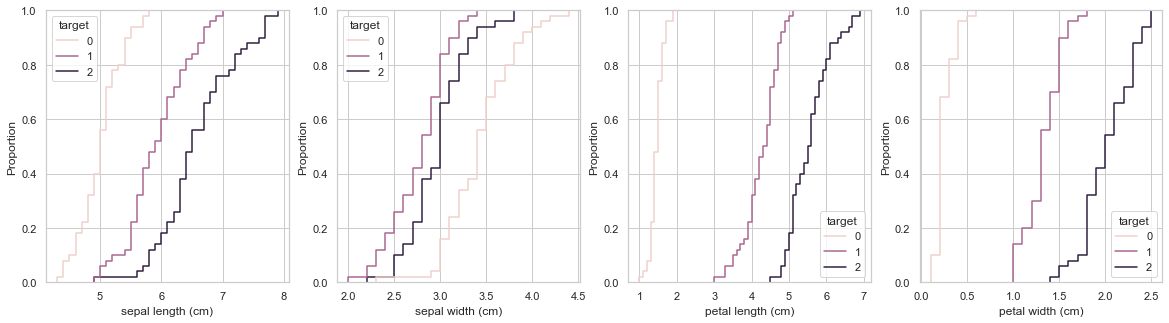

In [36]:
plots_ecdf(df1, dataset1.feature_names, 'target', ecdf, num_plots_per_row = 4)

## Analysis: titanic dataset

In [37]:
cols_cat_titanic

['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

In [38]:
analysis_msip(df2, 'survived', verbose = False)

pclass       age     sibsp     parch      fare samples_sizes
0-1  0.034469  0.505899  0.012478  0.003426  0.255064        59/123

In [46]:
analysis_msip(df2, 'sex', verbose = False)

survived    pclass       age     sibsp     parch      fare  \
male-female       0.0  0.000253  0.446239  0.028915  0.024416  0.499607   

            samples_sizes  
male-female         94/88

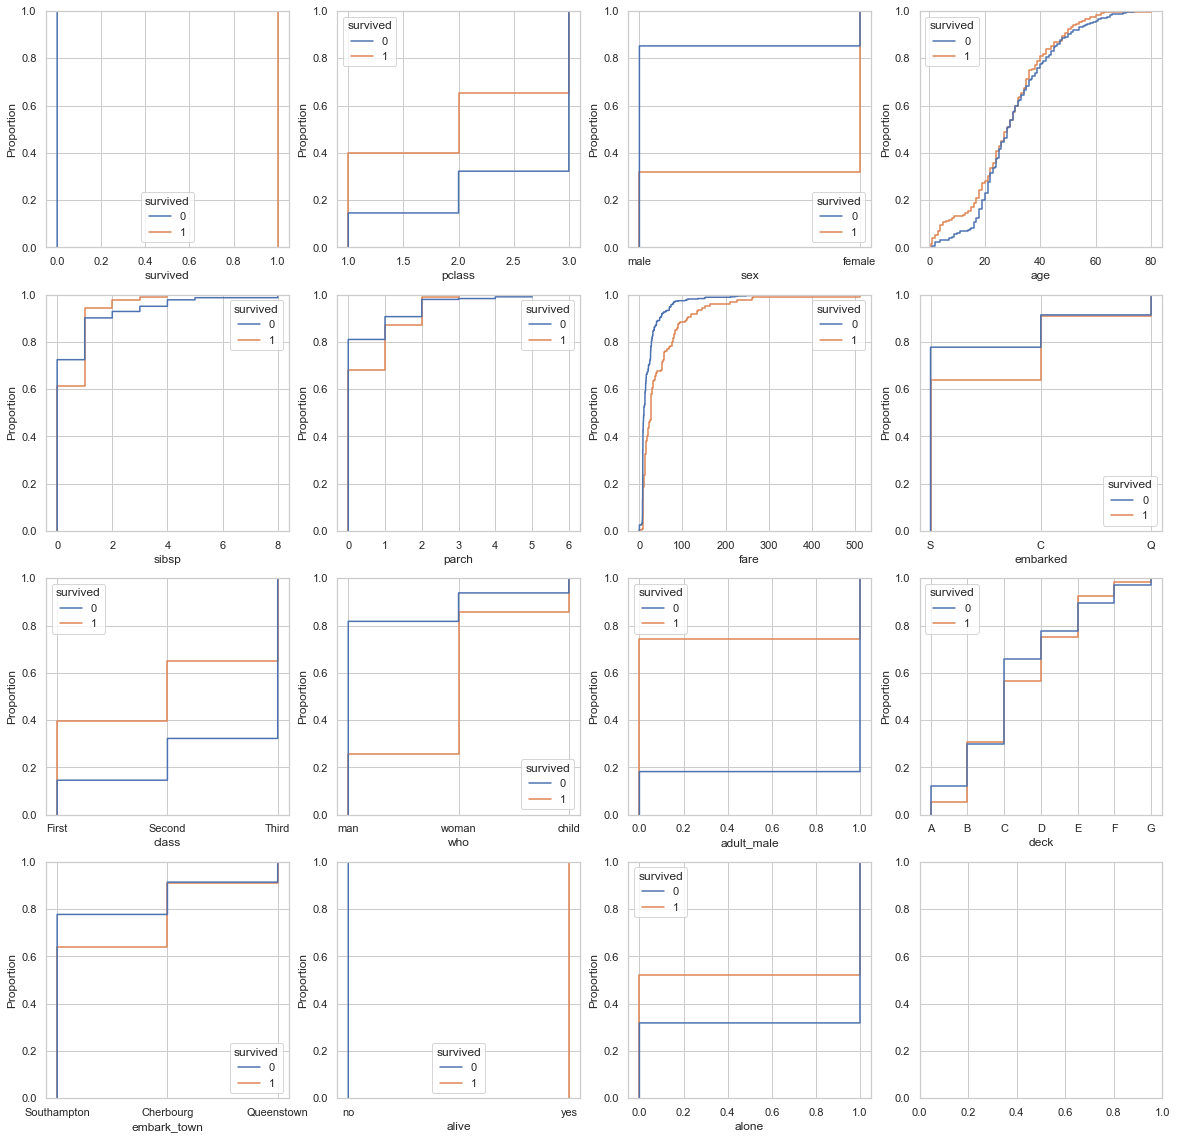

In [47]:
plots_ecdf(df2, df2.columns.tolist(), 'survived', ecdf, num_plots_per_row = 4)